## Example using kg

In [17]:
import pathlib,sys,itertools
sys.path.append('D:\GitHub\myKG')
from kg.measurement_values import measuredValues
from kg.measurement_signal import measuredSignal
from kg.detect import *
from kg.algorithm import *
from kg.case import Case
from kg.intervals import *
from kg.widgets import CompareCaseAlgWidget
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


setup measurement main directory 'D:\GitHub\myKG\Measurements_example\MBBMZugExample'



In [18]:
mesPath = pathlib.Path('D:\GitHub\myKG\Measurements_example\MBBMZugExample')
mesVal = measuredValues.from_json(mesPath)
measuredSignal.setup(mesPath)

list all variables in **mesVal**

In [19]:
mesVal.list_variables()

,description,variable
0,Regen in elektrische spannung?,rain
1,"Fahrtrichtung, 1 sud,0 nord",direction
2,Geschwindigkeit erstes Drehgestell,v1
3,Windgeschwindigkeit in [m/s],wind
4,ZugslÃ¤nghe in meter,trainLenght
5,Gleis im zug; von 1 bis 4,Gleis
6,None,axleProLenght
7,Temperatur in [K],Temp
8,Zeit,mTime
9,Relative Feuchte in %,humidity


### Initiate micSignal Object
parameter: ID, mic, signal,values

In [20]:
micSn = [MicSignal.from_measurement(mesVal, 'm_0101', 4),
        MicSignal.from_measurement(mesVal, 'm_0100', 6)]
#y, t, sR = mesSn.get_signal(mic)
#values = mesVal.get_variables_values(mID, mic, [ 'Tb','Te','Tp_b','Tp_e','LAEQ'])
#print(values)
#micSn = MicSignal(mID, mic, y, t, sR, values)

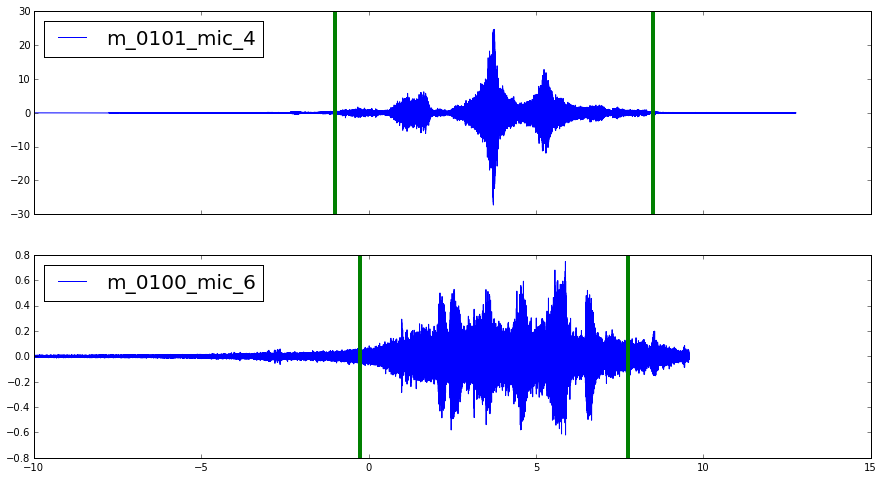

In [21]:
figsize(15,8)
fig, axes = plt.subplots(len(micSn), sharex = True)
for i, Sn in enumerate(micSn):
    ax = axes[i]
    Sn.plot_signal(ax)
    Sn.plot_triggers(ax,color='green',lw=4)
    #Sn.plot_triggers(ax,type = 'passby')
    ax.legend(loc=2,prop={'size':20})

### Initiate algorithm 
with parameter

In [28]:
algorithms =[ZischenDetetkt2(3000,4,0.02),ZischenDetetkt2(3000,3,0.05)]
print(repr(algorithms[0]))

ZischenDetetkt2
description: implement the Algorithm:
        1: stft -> X(k,i)
        2: calculate power per bands for every t_i
        3: build band power ratio (BPR) 
        4: smooth BPR with simple moving average
        5: compare  log10(1+BPR) to threshold for every t_i
        
parameter:
{'overlap': 6, 'fmin': 100, 'threshold': 4, 'fmax': 15000, 'fc': 3000, 'dt': 0.02}


### Test algorithms on cases

- first initiate two empty cases 
- then fill it with intervals

In [29]:
cases = {}
for Sn in micSn[0:1]:
    mID = Sn.ID
    mic = Sn.mic
    values = mesVal.get_variables_values(mID, mic, [ 'Tb','Te','Tp_b','Tp_e','LAEQ'])
    cases[str(Sn)]  = Case('Zug','Vormessung',mID,mic,values['Tb'], values['Te'],'esr')

cases[str(micSn[0])].case['Z'].append(Interval(0.5,5))
cases[str(micSn[1])] = Case.from_JSON(pathlib.Path('case_m_0100_6_esr.json'))

empty list


In [30]:
for alg in algorithms:
    for Sn in micSn:
        alg.test_on_case(cases[str(Sn)],mesVal,Sn)
    alg.calc_rates()
    print(alg.case_tests)

{'case_m_0101_4_esr': {'FP': 70, 'TP': 96, 'quality': None, 'author': 'esr', 'measurement': 'Vormessung', 'FN': 129, 'mID': 'm_0101', 'TN': 180, 'mic': 4, 'TNR': 0.72, 'location': 'Zug', 'TPR': 0.4266666666666667}, 'case_m_0100_6_esr': {'FP': 11, 'TP': 45, 'quality': 'medium', 'author': 'esr', 'measurement': 'Vormessung', 'FN': 64, 'mID': 'm_0100', 'TN': 280, 'mic': 6, 'TNR': 0.9621993127147767, 'location': 'Zug', 'TPR': 0.41284403669724773}}
{'case_m_0101_4_esr': {'FP': 35, 'TP': 48, 'quality': None, 'author': 'esr', 'measurement': 'Vormessung', 'FN': 42, 'mID': 'm_0101', 'TN': 65, 'mic': 4, 'TNR': 0.65, 'location': 'Zug', 'TPR': 0.5333333333333333}, 'case_m_0100_6_esr': {'FP': 7, 'TP': 33, 'quality': 'medium', 'author': 'esr', 'measurement': 'Vormessung', 'FN': 11, 'mID': 'm_0100', 'TN': 109, 'mic': 6, 'TNR': 0.9396551724137931, 'location': 'Zug', 'TPR': 0.75}}


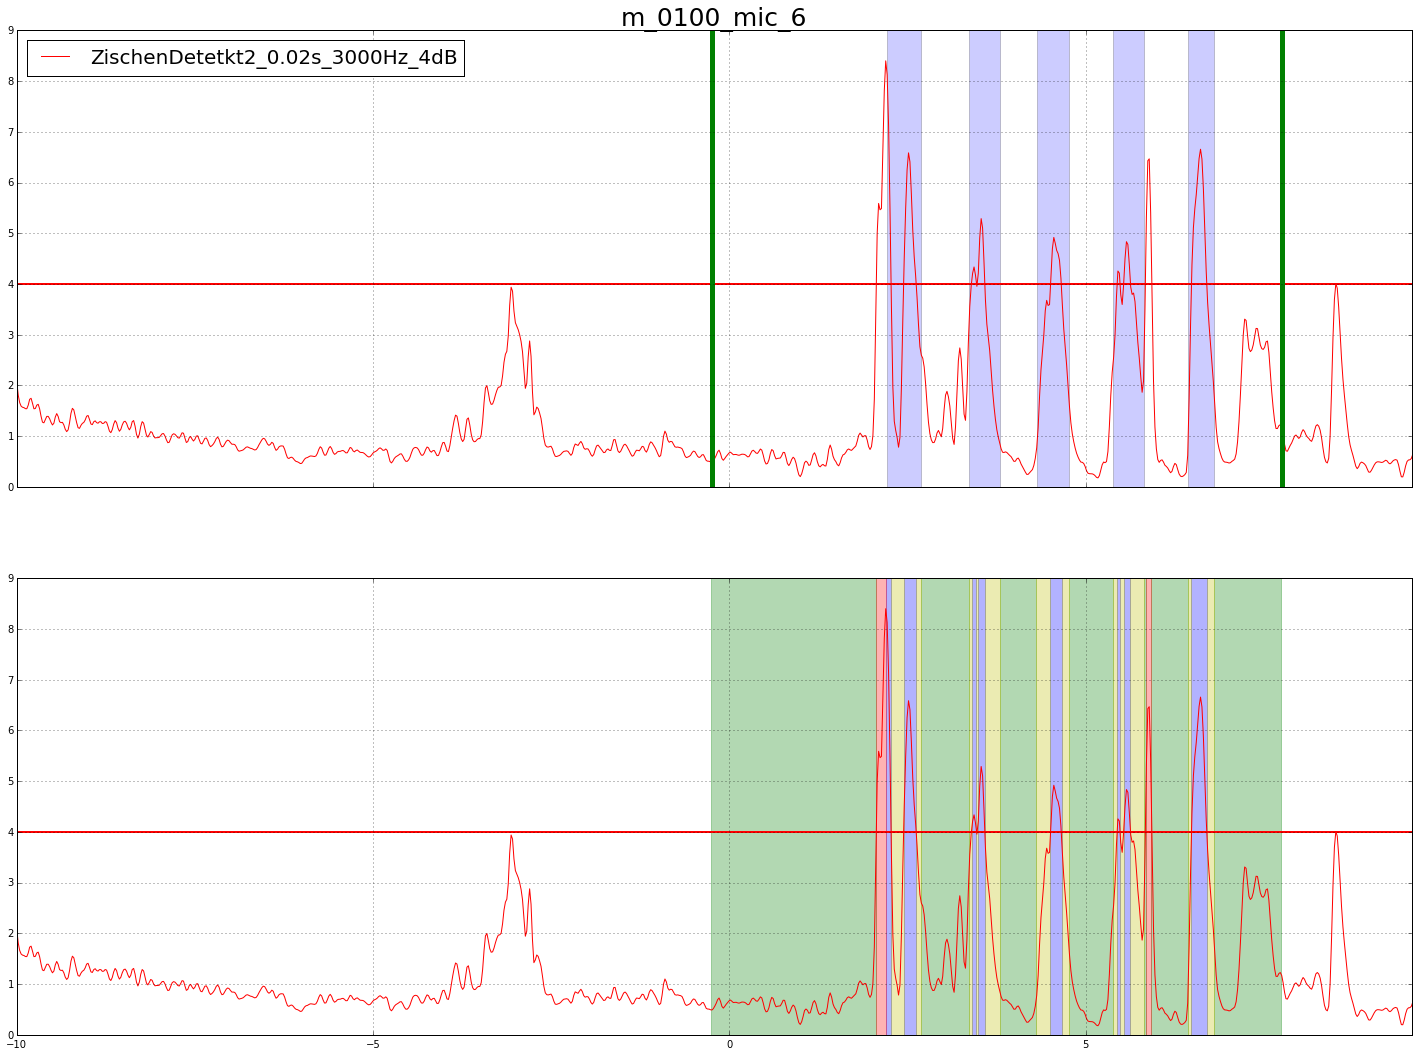

In [33]:
alg = algorithms[0]
Sn = micSn[1]
case = cases[str(Sn)]
#
figsize(25,18)
fig,axes = plt.subplots(2,sharex=True)
ax = axes[0]
Sn.plot_BPR(alg,ax, color = 'red')
Sn.plot_triggers(ax,color='green',lw=5)
case.plot(ax)
ax.set_xlim(Sn.t.min(),Sn.t.max())
ax.set_title(str(Sn),size=25)
ax.grid(True)
ax.legend(loc=2,prop={'size':20})
ax = axes[1]
Sn.plot_BPR(alg,ax, color = 'red')
alg_res = Sn.get_KG_results(alg)['result']
case.plot_compare(ax,alg_res['result'], alg_res['t'])
ax.grid(True)         
              

### visualize

In [34]:
%gui qt
W = CompareCaseAlgWidget(mesVal,case,algorithms)
W.show()

## calculate kg on micSn and set results to mesValues

In [36]:
for alg,Sn in itertools.product(algorithms,micSn):
    Sn.calc_kg(alg)

In [37]:
for alg,Sn in itertools.product(algorithms,micSn):
    mesVal.set_kg_values(alg,**Sn.get_KG_results(alg))

#### Save kg results to json

In [38]:
mesVal.kg_values_to_json()